# Modular Neural Network for CIFAR 10

In [ ]:
!pip install tensorflow==1.14.0
import tensorflow as tf

print(tf.__version__)

In [ ]:
!pip install h5py==2.10.0
import h5py
h5py.__version__


In the below lines of code, an attempt to implement MNN for CIFAR 10 dataset has been made. 

* Contents of dataset :  
> We have 60000 colour images of 32x32 
> These are dispersed in 10 different classes, 
> in which each class contains 6000 images
> In this 50000 images are used for training and 10000 for testing

* The model that has been implemented based on the [research paper](https://drive.google.com/file/d/1eLd8RO6nVFDBdYpXCGVngzabiVaIphKM/view?usp=sharing) :

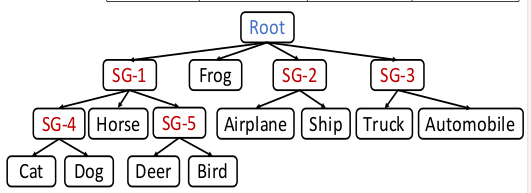



# 1. Loading the dataset and obtaining training and test sets

In [ ]:
# Importing libraries initially required
import matplotlib.pyplot as plots
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models,layers
from tensorflow.keras.datasets import cifar10


# loading cifar 10 dataset for training and testing.
#x--> Images, y--> labels
(img_train, label_train), (img_test, label_test) = cifar10.load_data()





# setting class names
c10_classes=['plane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
#----------0:g2,-----1:g3,-----2:g1,5---3:g1,4-----4:g1,5-----5:g1,4----6:g0---7:g1-----8:g2------9:g3

#normalizing the data
img_train=img_train/255.0
img_train.shape
img_test=img_test/255.0
img_test.shape

#reshaping 2D shape of labels to 1D
label_test = label_test.reshape(-1,)
label_train = label_train.reshape(-1,)
label_train = to_categorical(label_train, 10)
label_test = to_categorical(label_test, 10)



# 2. Defining MNN tree structure as modules of different sizes

##  Defining root module

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow.keras.backend
from tensorflow.keras.layers import Layer

def normalize_data_reference(data):
    if data is None:
        data = tensorflow.keras.backend.image_data_format()
    data_reference = data.lower()
    if data_reference not in {'channels_first', 'channels_last'}:
        raise ValueError('Please give an input that is part of  '
                         '"channels_first" or "channels_last". Cannot process ' +
                         str(data)+'data')
    return data_reference


class dwt_layer(Layer):
    def __init__(self, data_reference=None,**kwargs):
        super(dwt_layer, self).__init__(**kwargs)
        self.data_reference = normalize_data_reference(data_reference)

    def build(self, input_shape):
        super(dwt_layer, self).build(input_shape) 

    def call(self, n):
        return wavelet(n, self.data_reference)

    def compute_output_shape(self, input_shape):
        if self.data_reference == 'channels_first':
            return (input_shape[0], input_shape[1]*4, input_shape[2]//2, input_shape[3]//2)
        elif self.data_reference == 'channels_last':
            return (input_shape[0], input_shape[1]//2, input_shape[2]//2, input_shape[3]*4)


def wavelet(n, data_reference='channels_last'):
    if data_reference == 'channels_last':
        n1 = n[:, 0::2, 0::2, :] 
        n2 = n[:, 1::2, 0::2, :] 
        n3 = n[:, 0::2, 1::2, :] 
        n4 = n[:, 1::2, 1::2, :] 

    elif data_reference == 'channels_first':
        n1 = n[:, :, 0::2, 0::2] 
        n2 = n[:, :, 1::2, 0::2] 
        n3 = n[:, :, 0::2, 1::2] 
        n4 = n[:, :, 1::2, 1::2]      

    LL = n1 + n2 + n3 + n4
    LH = -n1 - n3 + n2 + n4
    HL = -n1 + n3 - n2 + n4
    HH = n1 - n3 - n2 + n4

    if data_reference == 'channels_last':
        return tensorflow.keras.backend.concatenate([LL,LH,HL,HH],axis=-1)
    elif data_reference == 'channels_first':
        return tensorflow.keras.backend.concatenate([LL,LH,HL,HH],axis=1)



Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

augment_gen = ImageDataGenerator( rotation_range=90, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
augment_gen.fit(img_train)

augment_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
augment_gen.fit(img_train)
 


In [ ]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plots
import pywt
import cv2

#defining root module
def root_module():

    root_conv= models.Sequential([
        layers.Conv2D(32,(3,3), activation = 'relu',  padding = 'same', input_shape = (32,32,3)),
        layers.Dropout(0.2),
        layers.Conv2D(32,(3,3), activation = 'relu', padding = 'same'),  
        layers.Dropout(0.2),
        
              ])   
    out= models.Sequential([
        root_conv #2
    ])
    out.add(dwt_layer()) #4
    out.add(layers.Flatten()) #5
    out.add(layers.Dense(128, activation = 'relu')) #6
    out.add(layers.Dropout(0.5))    #7
    out.add(layers.Dense(64, activation = 'relu')) #8
    out.add(layers.Dropout(0.5)) #9
    out.add(layers.Dense(10, activation = 'softmax') ) #10
    

    return root_conv,out
 

    
              
# vgg : 1 block - 10 layers


In [ ]:
root_conv,root=root_module()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
from tensorflow.keras.optimizers import SGD

sgd = SGD(lr=0.01, momentum=0.9, decay=0.001, nesterov=False) 

root.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
root.fit_generator(augment_gen.flow(img_train, label_train),steps_per_epoch = len(img_train)//32,epochs=30, verbose=1,validation_data=(img_test,label_test))


Epoch 1/30
1562/1562 [==============================] - 56s 36ms/step - loss: 1.4355 - acc: 0.4918 - val_loss: 1.2635 - val_acc: 0.5434
Epoch 2/30
1562/1562 [==============================] - 54s 35ms/step - loss: 1.4165 - acc: 0.4948 - val_loss: 1.1714 - val_acc: 0.5825
Epoch 3/30
1562/1562 [==============================] - 55s 35ms/step - loss: 1.4070 - acc: 0.4997 - val_loss: 1.1798 - val_acc: 0.5847
Epoch 4/30
1562/1562 [==============================] - 55s 35ms/step - loss: 1.3960 - acc: 0.5079 - val_loss: 1.1648 - val_acc: 0.5874
Epoch 5/30
1562/1562 [==============================] - 55s 35ms/step - loss: 1.3900 - acc: 0.5088 - val_loss: 1.1642 - val_acc: 0.5812
Epoch 6/30
1562/1562 [==============================] - 55s 35ms/step - loss: 1.3673 - acc: 0.5146 - val_loss: 1.1339 - val_acc: 0.5953
Epoch 7/30
1562/1562 [==============================] - 54s 35ms/step - loss: 1.3640 - acc: 0.5184 - val_loss: 1.1324 - val_acc: 0.5934
Epoch 8/30
1562/1562 [==========================

In [ ]:
root_path="/content/drive/MyDrive/01_Colab_MNN/root_DWT_final.h5py"
root.save(root_path)


In [ ]:
root.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 32, 32, 32)        10144     
_________________________________________________________________
dwt_layer (dwt_layer)        (None, 16, 16, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               4194432   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)               

##  Defining supergroup modules
* Root (level 0)- VGG block of size 1
* Supergroups at level 1 - VGG block of size 2
* Supergroups at level 2 - VGG block of size 3


In [ ]:
from tensorflow.keras import regularizers

def sg0_mod(root_conv):
    
    conv= models.Sequential([
    root_conv,
    dwt_layer(),
    layers.Conv2D(64,(3,3), activation = 'relu', padding = 'same'),
    layers.Conv2D(64,(3,3), activation = 'relu', padding = 'same'),
              ])   
    out= models.Sequential([
    conv
        ])#6
    out.add(dwt_layer())
    out.add(layers.Flatten())
    out.add(layers.Dense(1024, activation = 'relu'))
    out.add(layers.Dropout(0.2))   
    out.add(layers.Dense(512, activation = 'relu'))
    out.add(layers.Dropout(0.2)) #9
    out.add(layers.Dense(10, activation = 'softmax') )
    return out
              


#vgg : 2 block - 14 layers
sg0=sg0_mod(root_conv)

sg0.summary()



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 16, 16, 64)        120864    
_________________________________________________________________
dwt_layer_2 (dwt_layer)      (None, 8, 8, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              16778240  
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)              

In [ ]:
def sg1_mod(root_conv):
    
    conv= models.Sequential([
    root_conv,
    dwt_layer(),
    layers.Conv2D(64,(3,3), activation = 'relu', padding = 'same'),
    layers.Conv2D(64,(3,3), activation = 'relu', padding = 'same'),
              ])   
    out= models.Sequential([
    conv
        ])#6
    out.add(dwt_layer())
    out.add(layers.Flatten())
    out.add(layers.Dense(1024, activation = 'relu'))
    out.add(layers.Dropout(0.2))   
    out.add(layers.Dense(512, activation = 'relu'))
    out.add(layers.Dropout(0.2)) #9
    out.add(layers.Dense(10, activation = 'softmax') )
    return conv, out
#vgg : 2 block - 14 layers

from tensorflow.keras import regularizers
def sg2_mod(root_conv):
    
    conv= models.Sequential([
    root_conv,
    dwt_layer(),
    layers.Conv2D(64,(3,3), activation = 'relu', padding = 'same'),
    layers.Conv2D(64,(3,3), activation = 'relu', padding = 'same'),
              ])   
    out= models.Sequential([
    conv
        ])#6
    out.add(dwt_layer())
    out.add(layers.Flatten())
    out.add(layers.Dense(1024, activation = 'relu'))
    out.add(layers.Dropout(0.2))   
    out.add(layers.Dense(512, activation = 'relu'))
    out.add(layers.Dropout(0.2)) #9
    out.add(layers.Dense(10, activation = 'softmax') )
    return out


#vgg : 2 block - 14 layers




#vgg : 2 block - 14 layers

              
def sg3_mod(root_conv):
    
    conv= models.Sequential([
    root_conv,
    dwt_layer(),
    layers.Conv2D(64,(3,3), activation = 'relu', padding = 'same'),
    layers.Conv2D(64,(3,3), activation = 'relu', padding = 'same'),
              ])   
    out= models.Sequential([
    conv
        ])#6
    out.add(dwt_layer())
    out.add(layers.Flatten())
    out.add(layers.Dense(1024, activation = 'relu'))
    out.add(layers.Dropout(0.2))   
    out.add(layers.Dense(512, activation = 'relu'))
    out.add(layers.Dropout(0.2)) #9
    out.add(layers.Dense(10, activation = 'softmax') )
    return out
              
#14
              
def sg4_mod(sg_conv):
    
    conv= models.Sequential([
    sg_conv,
    layers.Conv2D(128,(3,3), activation = 'relu', padding = 'same'),
    layers.Conv2D(128,(3,3), activation = 'relu', padding = 'same'),
    ])   
    out= models.Sequential([
    conv
        ])#6
    out.add(layers.Flatten())
    out.add(layers.Dense(1024, activation = 'relu'))
    out.add(layers.Dropout(0.2))   
    out.add(layers.Dense(512, activation = 'relu'))
    out.add(layers.Dropout(0.2)) #9
    out.add(layers.Dense(10, activation = 'softmax') )
    return out
#vgg :  21 layers
              
def sg5_mod(sg_conv):
    
    conv= models.Sequential([
    sg_conv,
    dwt_layer(),
    layers.Conv2D(128,(3,3), activation = 'relu', padding = 'same'),
    layers.Conv2D(128,(3,3), activation = 'relu', padding = 'same'),
    ])   
    out= models.Sequential([
    conv
        ])#6
    out.add(layers.Flatten())
    out.add(layers.Dense(1024, activation = 'relu'))
    out.add(layers.Dropout(0.2))   
    out.add(layers.Dense(512, activation = 'relu'))
    out.add(layers.Dropout(0.2)) #9
    out.add(layers.Dense(10, activation = 'softmax') )
    return out
#vgg : 3 block -  17 layers

# 3. Loading  Root node

In [ ]:
root_path="/content/drive/MyDrive/01_Colab_MNN/root_DWT_final.h5py"

root_conv,root=root_module()

root = tf.keras.models.load_model(root_path, custom_objects={'dwt_layer':  dwt_layer})
#only for loading on colab

loss,va1= root.evaluate(img_test,label_test,8)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
10000/10000 [==============================] - 5s 517us/sample - loss: 1.0150 - acc: 0.6365


# 5. Training supergroups 

based on the condition that change in accuracy density is greater than threshold if it is lesser then the subgroup need not be trained

In [ ]:
'''
----------------0------------1---------2------3-----4-----5-------6------7------8-------9-----
c10_classes=['plane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
plane, car,  bird, cat,  deer,  dog,  frog,horse, ship, 
#----------0:g2,-----1:g3,-----2:g1,5---3:g1,4-----4:g1,5-----5:g1,4----6:g0---7:g1-----8:g2------9:g3
#frog--> 
#plane,ship :              0,8 --- > g2
#automobile,truck:            1,9 ---> g3
#bird,cat,deer,dog,horse:  2,3,4,5,7
#cat,dog --> sg4 (3,5)
#bird,deer --> sg5 (2,4)
###################################################################################################################################################
'''

import gc
gc.collect()


from tensorflow.keras.optimizers import SGD
import numpy as np

sgd = SGD(lr=0.01, momentum=0.9, decay=0.001, nesterov=False) 

y=len(label_test)

avg = np.mean(img_train,axis=(0,1,2,3))
SD = np.std(img_train,axis=(0,1,2,3))
img_train = (img_train-avg)/(SD+1e-7)
img_test = (img_test-avg)/(SD+1e-7)


sg0_path="/content/drive/MyDrive/01_Colab_MNN/sg0.h5"
sg2_path="/content/drive/MyDrive/01_Colab_MNN/sg2.h5"
sg1_path="/content/drive/MyDrive/01_Colab_MNN/sg1.h5"
sg3_path="/content/drive/MyDrive/01_Colab_MNN/sg3.h5"
sg4_path="/content/drive/MyDrive/01_Colab_MNN/sg4.h5"
sg5_path="/content/drive/MyDrive/01_Colab_MNN/sg5.h5"

## Training Supergroup 0

In [ ]:
root_conv,root=root_module()

for i in range(y):
    if np.argmax(label_test[i]) in [6] :
            print('super group 0 : AD = ',AD0)
            sg0=sg0_mod(root_conv)
            sg0.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
            sg0.fit_generator(augment_gen.flow(img_train, label_train),steps_per_epoch = len(img_train)//32,epochs=15, verbose=1,validation_data=(img_test,label_test))
            loss,va2=sg0.evaluate(img_test,label_test)
            va_g0=va2
            MS2=21
            gc.collect()
            sg0.save(sg1_path)
            

print("Accuracy: %.2f%%" % (va2*100))


super group 0 : AD =  6.365000009536743
Epoch 1/15
1562/1562 [==============================] - 108s 69ms/step - loss: 3.0744 - acc: 0.3993 - val_loss: 1.5824 - val_acc: 0.5433
Epoch 2/15
1562/1562 [==============================] - 101s 65ms/step - loss: 1.5314 - acc: 0.5270 - val_loss: 1.3404 - val_acc: 0.5822
Epoch 3/15
1562/1562 [==============================] - 102s 65ms/step - loss: 1.3512 - acc: 0.5832 - val_loss: 1.1620 - val_acc: 0.6636
Epoch 4/15
1562/1562 [==============================] - 106s 68ms/step - loss: 1.2560 - acc: 0.6197 - val_loss: 1.1490 - val_acc: 0.6659
Epoch 5/15
1562/1562 [==============================] - 109s 70ms/step - loss: 1.1810 - acc: 0.6496 - val_loss: 1.0635 - val_acc: 0.6888
Epoch 6/15
1562/1562 [==============================] - 107s 69ms/step - loss: 1.1338 - acc: 0.6668 - val_loss: 0.9901 - val_acc: 0.7158
Epoch 7/15
1562/1562 [==============================] - 106s 68ms/step - loss: 1.0935 - acc: 0.6805 - val_loss: 0.9451 - val_acc: 0.7338
E

## Training Supergroup 2


In [ ]:
for i in range(y):
    if np.argmax(label_test[i]) in [0,8] :
            sg2=sg2_mod(root_conv)
            sg2.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
            sg2.fit_generator(augment_gen.flow(img_train, label_train),steps_per_epoch = len(img_train)//32,epochs=15, verbose=1,validation_data=(img_test,label_test))
            loss,va2=sg2.evaluate(img_test,label_test)
            va_g2=va2
            sg2.save(sg2_path)
            break
gc.collect()



Epoch 1/15
1562/1562 [==============================] - 127s 81ms/step - loss: 1.6850 - acc: 0.3936 - val_loss: 1.2649 - val_acc: 0.5421
Epoch 2/15
1562/1562 [==============================] - 122s 78ms/step - loss: 1.3269 - acc: 0.5199 - val_loss: 1.1155 - val_acc: 0.6017
Epoch 3/15
1562/1562 [==============================] - 123s 79ms/step - loss: 1.1978 - acc: 0.5720 - val_loss: 1.0729 - val_acc: 0.6299
Epoch 4/15
1562/1562 [==============================] - 132s 84ms/step - loss: 1.1187 - acc: 0.6013 - val_loss: 1.0281 - val_acc: 0.6452
Epoch 5/15
1562/1562 [==============================] - 134s 86ms/step - loss: 1.0645 - acc: 0.6217 - val_loss: 0.8930 - val_acc: 0.6845
Epoch 6/15
1562/1562 [==============================] - 127s 82ms/step - loss: 1.0263 - acc: 0.6337 - val_loss: 0.9265 - val_acc: 0.6763
Epoch 7/15
1562/1562 [==============================] - 122s 78ms/step - loss: 0.9941 - acc: 0.6453 - val_loss: 0.8876 - val_acc: 0.6900
Epoch 8/15
1562/1562 [===================

554

## Training Supergroup 3

In [ ]:
AD3=AD_temp
for i in range(y):
    if np.argmax(label_test[i]) in [1,9] :
            print('Super group 3 : AD = ',AD3)
            sg3=sg3_mod(root_conv)
            sg3.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
            sg3.fit_generator(augment_gen.flow(img_train, label_train),steps_per_epoch = len(img_train)//32,epochs=15, verbose=1,validation_data=(img_test,label_test))
            loss,va2=sg3.evaluate(img_test,label_test)
            AD3=delta_AD(va1,va2,MS1,MS2)
            va_g3=va2
            sg3.save(sg3_path)
            break
gc.collect()



Super group 3 : AD =  6.365000009536743
Epoch 1/15
1562/1562 [==============================] - 132s 84ms/step - loss: 1.7649 - acc: 0.3570 - val_loss: 1.3092 - val_acc: 0.5298
Epoch 2/15
1562/1562 [==============================] - 126s 80ms/step - loss: 1.3857 - acc: 0.4976 - val_loss: 1.1582 - val_acc: 0.5864
Epoch 3/15
1562/1562 [==============================] - 117s 75ms/step - loss: 1.2552 - acc: 0.5487 - val_loss: 1.0932 - val_acc: 0.6165
Epoch 4/15
1562/1562 [==============================] - 113s 72ms/step - loss: 1.1840 - acc: 0.5763 - val_loss: 1.0098 - val_acc: 0.6482
Epoch 5/15
1562/1562 [==============================] - 122s 78ms/step - loss: 1.1196 - acc: 0.6010 - val_loss: 0.9660 - val_acc: 0.6596
Epoch 6/15
1562/1562 [==============================] - 126s 80ms/step - loss: 1.0798 - acc: 0.6139 - val_loss: 0.9389 - val_acc: 0.6744
Epoch 7/15
1562/1562 [==============================] - 123s 79ms/step - loss: 1.0451 - acc: 0.6272 - val_loss: 0.9429 - val_acc: 0.6719
E

## Training Supergroup 1 

In [ ]:

for i in range(y):
    if np.argmax(label_test[i]) in [2,3,4,5,7] : #g5--> horse
            sg1_conv,sg1=sg1_mod(root_conv)
            sg1.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
            sg1.fit_generator(augment_gen.flow(img_train, label_train),steps_per_epoch = len(img_train)//32,epochs=15, verbose=1,validation_data=(img_test,label_test))
            loss,va2=sg1.evaluate(img_test,label_test)
            sg1.save(sg1_path)
            va_g1=va2
            break



Epoch 1/15
1562/1562 [==============================] - 123s 79ms/step - loss: 0.8700 - acc: 0.6899 - val_loss: 0.7736 - val_acc: 0.7316
Epoch 2/15
1562/1562 [==============================] - 132s 85ms/step - loss: 0.8589 - acc: 0.6951 - val_loss: 0.7811 - val_acc: 0.7314
Epoch 3/15
1562/1562 [==============================] - 133s 85ms/step - loss: 0.8506 - acc: 0.6970 - val_loss: 0.7974 - val_acc: 0.7266
Epoch 4/15
1562/1562 [==============================] - 139s 89ms/step - loss: 0.8434 - acc: 0.7007 - val_loss: 0.7900 - val_acc: 0.7305
Epoch 5/15
1562/1562 [==============================] - 134s 86ms/step - loss: 0.8363 - acc: 0.7024 - val_loss: 0.7576 - val_acc: 0.7406
Epoch 6/15
1562/1562 [==============================] - 124s 80ms/step - loss: 0.8273 - acc: 0.7080 - val_loss: 0.7559 - val_acc: 0.7442
Epoch 7/15
1562/1562 [==============================] - 131s 84ms/step - loss: 0.8222 - acc: 0.7103 - val_loss: 0.7587 - val_acc: 0.7377
Epoch 8/15
1562/1562 [===================

In [ ]:
sg1.save(sg1_path)
loss,va2=sg1.evaluate(img_test,label_test)

va_g1=va2


10000/10000 [==============================] - 6s 609us/sample - loss: 0.7271 - acc: 0.7506


Training Supergroup 4

In [ ]:
sg1_conv,sg1=sg1_mod(root_conv)
for i in range(y):
    if np.argmax(label_test[i]) in [3,5] : #g5--> horse
                sg4=sg4_mod(sg1_conv)
                sg4.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
                sg4.fit_generator(augment_gen.flow(img_train, label_train),steps_per_epoch = len(img_train)//32,epochs=15, verbose=1,validation_data=(img_test,label_test))
                loss,va2=sg4.evaluate(img_test,label_test)
                sg4.save(sg4_path)
                va_g4=va2
                break
                
                


Epoch 1/15
1562/1562 [==============================] - 178s 114ms/step - loss: 1.6435 - acc: 0.3923 - val_loss: 1.2519 - val_acc: 0.5432
Epoch 2/15
1562/1562 [==============================] - 188s 120ms/step - loss: 1.2475 - acc: 0.5473 - val_loss: 1.0378 - val_acc: 0.6258
Epoch 3/15
1562/1562 [==============================] - 203s 130ms/step - loss: 1.0787 - acc: 0.6157 - val_loss: 1.0526 - val_acc: 0.6419
Epoch 4/15
1562/1562 [==============================] - 212s 136ms/step - loss: 0.9627 - acc: 0.6588 - val_loss: 0.8479 - val_acc: 0.7017
Epoch 5/15
1562/1562 [==============================] - 229s 147ms/step - loss: 0.8902 - acc: 0.6851 - val_loss: 0.7893 - val_acc: 0.7267
Epoch 6/15
1562/1562 [==============================] - 230s 147ms/step - loss: 0.8226 - acc: 0.7087 - val_loss: 0.7558 - val_acc: 0.7393
Epoch 7/15
1562/1562 [==============================] - 197s 126ms/step - loss: 0.7809 - acc: 0.7263 - val_loss: 0.6888 - val_acc: 0.7654
Epoch 8/15
1562/1562 [============

## Training Supergroup 5

In [ ]:

for i in range(y):
    if np.argmax(label_test[i]) in [2,3,4,5,7] : #g5--> horse
            if (np.argmax(label_test[i]) in  [2,4]): 
                sg5=sg5_mod(sg1_conv)
                sg5.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
                sg5.fit_generator(augment_gen.flow(img_train, label_train),steps_per_epoch = len(img_train)//32,epochs=15, verbose=1,validation_data=(img_test,label_test))
                loss,va2=sg5.evaluate(img_test,label_test)
                sg5.save(sg5_path)
                va_g5=va2
                break
        


Epoch 1/15
1562/1562 [==============================] - 135s 87ms/step - loss: 1.3315 - acc: 0.5235 - val_loss: 0.9567 - val_acc: 0.6623
Epoch 2/15
1562/1562 [==============================] - 137s 87ms/step - loss: 1.0234 - acc: 0.6354 - val_loss: 0.8430 - val_acc: 0.7078
Epoch 3/15
1562/1562 [==============================] - 139s 89ms/step - loss: 0.9312 - acc: 0.6723 - val_loss: 0.8574 - val_acc: 0.7042
Epoch 4/15
1562/1562 [==============================] - 135s 87ms/step - loss: 0.8723 - acc: 0.6941 - val_loss: 0.7976 - val_acc: 0.7228
Epoch 5/15
1562/1562 [==============================] - 134s 86ms/step - loss: 0.8414 - acc: 0.7055 - val_loss: 0.7596 - val_acc: 0.7381
Epoch 6/15
1562/1562 [==============================] - 136s 87ms/step - loss: 0.8062 - acc: 0.7154 - val_loss: 0.7060 - val_acc: 0.7574
Epoch 7/15
1562/1562 [==============================] - 133s 85ms/step - loss: 0.7768 - acc: 0.7266 - val_loss: 0.7012 - val_acc: 0.7604
Epoch 8/15
1562/1562 [===================

In [ ]:
sg5_path="/content/drive/MyDrive/01_Colab_MNN/sg5_DWT_new.h5py"
sg5.save(sg5_path)

# loading from saved weights and checking accuracy

In [ ]:
va_list=[]
path="/content/drive/MyDrive/01_Colab_MNN/"
file_list=[]
for i in range(6):
  file_name='sg'+str(i)+'.h5'
  file_path=str(path+file_name)
  file = tf.keras.models.load_model(file_path, custom_objects={'dwt_layer':  dwt_layer})
  loss,va= file.evaluate(img_test,label_test,8)
  va_list.append(va)
  file_list.append(str(file_name))
  print('\n',str(file_name),' ',va)
  

10000/10000 [==============================] - 14s 1ms/sample - loss: 0.8699 - acc: 0.7608

 sg0.h5   0.7608
10000/10000 [==============================] - 16s 2ms/sample - loss: 0.7271 - acc: 0.7506

 sg1.h5   0.7506
10000/10000 [==============================] - 17s 2ms/sample - loss: 0.7449 - acc: 0.7398

 sg2.h5   0.7398
10000/10000 [==============================] - 19s 2ms/sample - loss: 0.8124 - acc: 0.7203

 sg3.h5   0.7203
10000/10000 [==============================] - 23s 2ms/sample - loss: 0.5790 - acc: 0.8061

 sg4.h5   0.8061
10000/10000 [==============================] - 22s 2ms/sample - loss: 0.6339 - acc: 0.7873

 sg5.h5   0.7873


# 7. Checking to ensure improvement in accuracy

In [ ]:
for i in range(6):
  if va_list[i]!=0:
    print("Accuracy of supergroup "+str(i)+':\t',(va_list[i]*100))


Accuracy of supergroup 0:	 76.08000040054321
Accuracy of supergroup 1:	 75.05999803543091
Accuracy of supergroup 2:	 73.9799976348877
Accuracy of supergroup 3:	 72.0300018787384
Accuracy of supergroup 4:	 80.61000108718872
Accuracy of supergroup 5:	 78.72999906539917


In [ ]:
print("Accuracy of root node :",va1*100)
for i in range(6):
    if va_list[i]>va1:
        print("Supergroup ",i," has improved from ",va1*100,"% to ",va_list[i]*100,"% .","\tBy ",(va_list[i]-va1)*100,'%')

Accuracy of root node : 63.65000009536743
Supergroup  0  has improved from  63.65000009536743 % to  76.08000040054321 % . 	By  12.430000305175781 %
Supergroup  1  has improved from  63.65000009536743 % to  75.05999803543091 % . 	By  11.409997940063477 %
Supergroup  2  has improved from  63.65000009536743 % to  73.9799976348877 % . 	By  10.329997539520264 %
Supergroup  3  has improved from  63.65000009536743 % to  72.0300018787384 % . 	By  8.380001783370972 %
Supergroup  4  has improved from  63.65000009536743 % to  80.61000108718872 % . 	By  16.96000099182129 %
Supergroup  5  has improved from  63.65000009536743 % to  78.72999906539917 % . 	By  15.079998970031738 %
